Regularization is a technique used in machine learning and neural networks to prevent overfitting and improve the generalization performance of models. Overfitting occurs when a model learns to fit the training data too closely, capturing noise and irrelevant patterns, which leads to poor performance on unseen data.The following illustration, called the generalization curve, shows that the training loss keeps decreasing by increasing the number of training iterations:

![](https://i.imgur.com/j6P8EPq.png)

Regularization methods introduce additional constraints or penalties on the model's parameters during training, encouraging simpler models that are less likely to overfit. These constraints can take various forms:
* L1 regularization (Lasso)
* L2 regularization (Ridge)
* Dropout
* Early stopping
* Data augmentation

Here's why regularization is needed:

* Preventing Overfitting: The primary purpose of regularization is to prevent overfitting, where a model memorizes the training data instead of learning generalizable patterns. By imposing constraints on the model's parameters, regularization helps to smooth the learning process and reduce the complexity of the learned function, leading to better generalization to unseen data.

* Improving Generalization: Regularization encourages the model to learn simpler and smoother decision boundaries, which are less sensitive to noise and variations in the training data. This improves the model's ability to generalize well to new, unseen examples, leading to better performance on real-world data.

## Importing Libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import torchvision.models as models
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import numpy as np
import random
import gc
  # Set random seed for reproducibility
random.seed(0)
torch.manual_seed(42)
np.random.seed(0)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True


## No regularisation

### Architecture

In [ ]:
class MyNet(nn.Module):
    def __init__(self, num_classes):
        super(MyNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),  # Convolutional layer
            nn.ReLU(True),
            nn.MaxPool2d(2, 2), #Pooling layer
            #nn.Dropout(),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        #self.classifier = nn.Sequential(*list(pretrained_alexnet.classifier.children())[:-1])  # Remove last fully connected layer
        self.classifier = nn.Sequential(
            nn.Linear(44944, 10000),  # New fully connected layer
            nn.ReLU(True),
            nn.Linear(10000, 1000),  # New fully connected layer
            nn.ReLU(True),
            #nn.Dropout(),
            nn.Linear(1000, 120),  # New fully connected layer
            nn.ReLU(True),
            nn.Linear(120, 84),
            nn.ReLU(True),
            #nn.Dropout(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

### Utils Functions

In [ ]:
## Counting parameters

def count_parameters(modelRef):
    return sum(p.numel() for p in modelRef.parameters() if p.requires_grad)


# Define a function to filter CIFAR-10 dataset for cat and dog classes
def filter_cifar(dataset, classes):
    filtered_indices = []
    for i in range(len(dataset)):
        # Check if the label corresponds to cat or dog
        if dataset.targets[i] in classes:
            filtered_indices.append(i)
    filtered_dataset = torch.utils.data.Subset(dataset, filtered_indices)
    return filtered_dataset

def getLoader(train_transform,test_transform):

  # Load CIFAR-10 dataset
  train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
  test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform= test_transform)



  # Define classes for cat and dog
  cat_class = 3  # Label for cat class in CIFAR-10
  dog_class = 9  # Label for dog class in CIFAR-10

  # Filter CIFAR-10 dataset for cat and dog classes
  train_dataset = filter_cifar(train_dataset, classes=[cat_class, dog_class])
  test_dataset =  filter_cifar(test_dataset, classes=[cat_class, dog_class])

  # Split train_dataset into train and validation sets
  # Split the training dataset into two parts
  print(len(train_dataset))
  train_size = len(train_dataset) // 16  ## Reducing the dataset size
  train_dataset, _ = random_split(train_dataset, [train_size, len(train_dataset) - train_size])
  train_size = int(0.8 * len(train_dataset))
  print("Training dataset size = ",train_size)
  val_size = len(train_dataset) - train_size
  print("Validation dataset size = ",val_size)
  # Use torch.Generator to create a generator with a specific seed
#   generator = torch.Generator()
#   generator.manual_seed(0)
  train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

  # Define dataloaders
  train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
  print("Test dataset size = ",len(test_dataset))
  return train_loader,val_loader,test_loader


import matplotlib.pyplot as plt

def plot_fig(refTrainLoss, refValLoss, refValAcc, refTrainAcc, trainLoss, valLoss, valAcc, trainAcc):
    #num_epochs_ref = len(refTrainLoss)  # Assuming all lists have the same length
    num_epochs = len(trainLoss)
    # Create subplots with 2 rows and 2 columns
    if refTrainLoss != None:

        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        num_epochs_ref = len(refTrainLoss)
        # Plot reference loss
        axes[0, 0].plot(range(1, num_epochs_ref + 1), refTrainLoss, label='Reference Train Losses', color='blue')
        axes[0, 0].plot(range(1, num_epochs_ref + 1), refValLoss, label='Reference Validation Loss', color='red')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()

        # Plot actual loss
        axes[0, 1].plot(range(1, num_epochs + 1), trainLoss, label='Train Losses', color='blue')
        axes[0, 1].plot(range(1, num_epochs + 1), valLoss, label='Validation Loss', color='red')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()

        # Plot reference accuracy
        axes[1, 0].plot(range(1, num_epochs_ref + 1), refTrainAcc, label='Reference Val Acc', color='blue')
        axes[1, 0].plot(range(1, num_epochs_ref + 1), refValAcc, label='Reference Val Acc', color='red')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].legend()

        # Plot actual accuracy
        axes[1, 1].plot(range(1, num_epochs + 1), trainAcc, label='Train Acc', color='blue')
        axes[1, 1].plot(range(1, num_epochs + 1), valAcc, label='Val Acc', color='red')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

    else:

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
                # Plot actual loss
        axes[0].plot(range(1, num_epochs + 1), trainLoss, label='Train Losses', color='blue')
        axes[0].plot(range(1, num_epochs + 1), valLoss, label='Validation Loss', color='red')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()

                # Plot actual accuracy
        axes[1].plot(range(1, num_epochs + 1), trainAcc, label='Train Acc', color='blue')
        axes[1].plot(range(1, num_epochs + 1), valAcc, label='Val Acc', color='red')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()

        plt.tight_layout()
        plt.show()



# Example usage:
# plot_fig(refTrainLoss, refValLoss, refValAcc, refTrainAcc, trainLoss, valLoss, valAcc, trainAcc)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    # Train the model
    best_val_loss = float('inf')
    best_model_path = 'best_model.pth'
    train_losses = []
    val_losses = []
    val_acc_list = []
    train_acc_list = []
    pbar = tqdm(train_loader, position=0, leave=True)
    pbar_val = tqdm(val_loader, position=0, leave=True)
    for epoch in range(num_epochs):
        model.train()
        pbar.reset()
        pbar_val.reset()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            total += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            pbar.update(1)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_acc_list.append(train_accuracy)
        train_losses.append(epoch_loss)
        #print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2%}")

        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():

            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar_val.update(1)
                pbar_val.set_description(f"Epoch {epoch+1}/{num_epochs}")

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct / total
        val_acc_list.append(val_accuracy)



    return train_losses, val_losses, val_acc_list, train_acc_list


def evaluate_model(model, test_loader, criterion):
    # Load the best model
    #model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

    # Set model to evaluation mode
    model.eval()

    # Initialize variables for loss and accuracy
    test_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    targets = []

    with torch.no_grad():
        pbar_test = tqdm(test_loader, position=0, leave=True)
        for inputs, labels in pbar_test:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())
            pbar_test.set_description(f"Test Loss: {test_loss/len(test_loader.dataset):.4f}, Test Accuracy: {(correct / total):.2%}")

    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}")

    return test_loss, test_accuracy

In [ ]:
# Define the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the model
num_classes = 10  # CIFAR-10 has 10 classes
modelRef = MyNet(num_classes=num_classes).to(device)

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values to range [-1, 1]
])
train_loader,val_loader,test_loader = getLoader(transform, transform)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelRef.parameters(), lr=0.001)

print("Total Prameters = ",count_parameters(modelRef)/1e6, "M")

ref_train_losses, ref_val_losses, ref_val_acc_list, ref_train_acc_list = train_model(modelRef, train_loader, val_loader, criterion, optimizer, num_epochs= 50)




100%|██████████| 170498071/170498071 [00:05<00:00, 34030540.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
10000
Training dataset size =  500
Validation dataset size =  125
Test dataset size =  2000
Total Prameters =  459.585006 M


Epoch 50/50: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


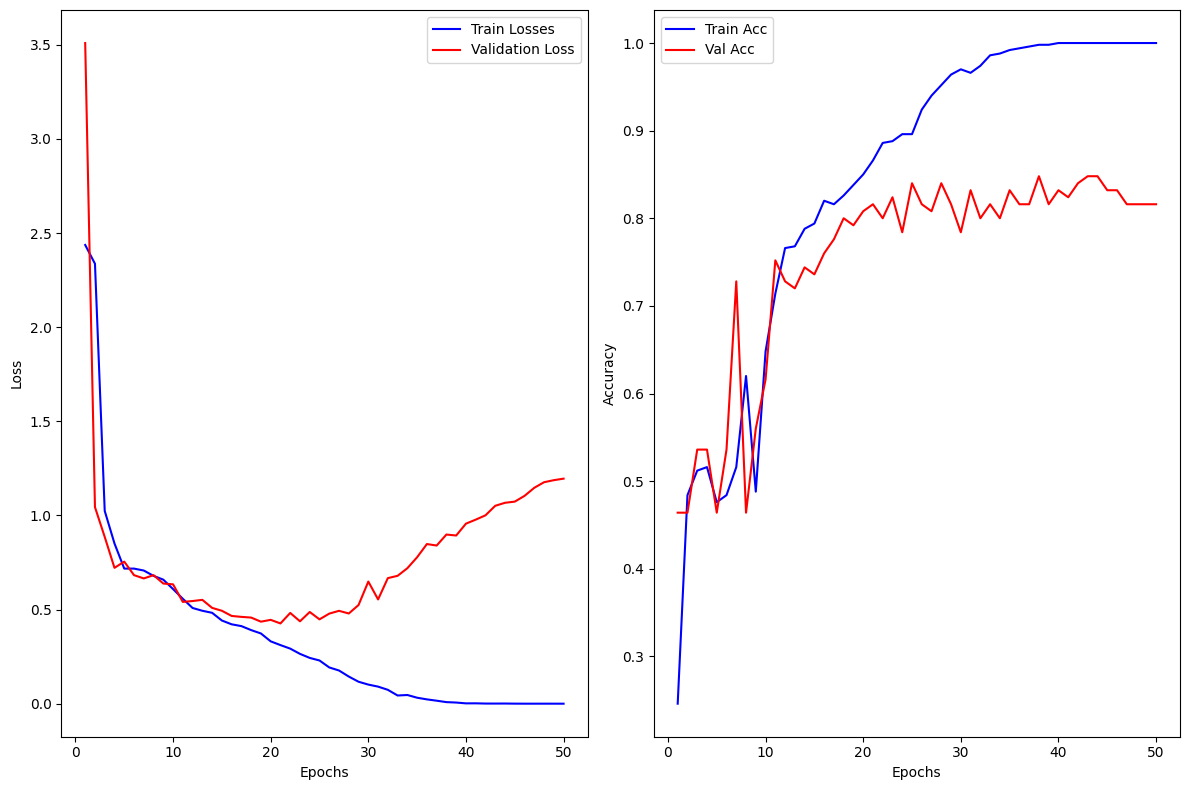

In [ ]:
plot_fig(refTrainLoss = None, refValLoss = None, refValAcc = None, refTrainAcc = None, trainLoss = ref_train_losses, valLoss = ref_val_losses, valAcc = ref_val_acc_list, trainAcc = ref_train_acc_list)

In [ ]:
# Example usage:
evaluate_model(modelRef, test_loader, criterion)

Test Loss: 1.2348, Test Accuracy: 82.90%: 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

Test Loss: 1.2348, Test Accuracy: 82.90%


(1.2348261618614196, 0.829)

In [ ]:
del modelRef
gc.collect()
torch.cuda.empty_cache()
#torch.save(model.state_dict(), '/kaggle/working/ref_model.pth')

In [ ]:
print("ref_train_losses = ",ref_train_losses)
print("ref_val_losses = ",ref_val_losses)
print("ref_val_acc_list = ",ref_val_acc_list)
print("ref_train_acc_list = ",ref_train_acc_list)

ref_train_losses =  [2.436741792678833, 2.337213949203491, 1.023976245880127, 0.8512363266944886, 0.7177285027503967, 0.7177145657539368, 0.7074700527191162, 0.6791732177734375, 0.658997350692749, 0.6089498591423035, 0.5572625780105591, 0.508527569770813, 0.4937185864448547, 0.48280247950553895, 0.44194583415985106, 0.4217806828022003, 0.41221767950057986, 0.3909915359020233, 0.37309602117538454, 0.33128810572624207, 0.3113966739177704, 0.2926714923381805, 0.26479482686519623, 0.2432701905965805, 0.2296401629447937, 0.1926880373954773, 0.1763547008037567, 0.14425995898246766, 0.11668597066402435, 0.10161966305971146, 0.09076639169454574, 0.0737989499270916, 0.04363103456795216, 0.046309160083532336, 0.03184061549603939, 0.023045460026711227, 0.01602441365271807, 0.008457044161856175, 0.006218128090724349, 0.0018793589640408754, 0.0020981821864843367, 0.0008786691352725029, 0.0007968551963567734, 0.0009722817977890373, 0.00040367676387541, 0.000219873578986153, 0.0002191728289471939, 0.

In [ ]:
#ref_train_losses =  [2.436741792678833, 2.337213949203491, 1.023976245880127, 0.8512363266944886, 0.7177285027503967, 0.7177145657539368, 0.7074700527191162, 0.6791732177734375, 0.658997350692749, 0.6089498591423035, 0.5572625780105591, 0.508527569770813, 0.4937185864448547, 0.48280247950553895, 0.44194583415985106, 0.4217806828022003, 0.41221767950057986, 0.3909915359020233, 0.37309602117538454, 0.33128810572624207, 0.3113966739177704, 0.2926714923381805, 0.26479482686519623, 0.2432701905965805, 0.2296401629447937, 0.1926880373954773, 0.1763547008037567, 0.14425995898246766, 0.11668597066402435, 0.10161966305971146, 0.09076639169454574, 0.0737989499270916, 0.04363103456795216, 0.046309160083532336, 0.03184061549603939, 0.023045460026711227, 0.01602441365271807, 0.008457044161856175, 0.006218128090724349, 0.0018793589640408754, 0.0020981821864843367, 0.0008786691352725029, 0.0007968551963567734, 0.0009722817977890373, 0.00040367676387541, 0.000219873578986153, 0.0002191728289471939, 0.00026289781893137844, 0.00023831211728975177, 0.00015539206098765134]
#ref_val_losses =  [3.509371519088745, 1.0442183017730713, 0.8858582377433777, 0.7217407822608948, 0.7546617984771729, 0.6828873157501221, 0.6654807925224304, 0.6828714609146118, 0.638444721698761, 0.6340671181678772, 0.5408132672309875, 0.5454109907150269, 0.5517178177833557, 0.5090718865394592, 0.49369722604751587, 0.46628132462501526, 0.4612675607204437, 0.4575551748275757, 0.4358152747154236, 0.4455219507217407, 0.4263525903224945, 0.48218682408332825, 0.4378274977207184, 0.48723721504211426, 0.44811391830444336, 0.47861823439598083, 0.4934455156326294, 0.4792255163192749, 0.5243303775787354, 0.6488884091377258, 0.5539118647575378, 0.6671238541603088, 0.6794299483299255, 0.7198212742805481, 0.7782139778137207, 0.8481647968292236, 0.8401844501495361, 0.8986678719520569, 0.8934126496315002, 0.9564935564994812, 0.9777429103851318, 1.0007202625274658, 1.0513436794281006, 1.0672956705093384, 1.0734648704528809, 1.1040081977844238, 1.146945595741272, 1.1765352487564087, 1.1873701810836792, 1.1955163478851318]
#ref_val_acc_list =  [0.464, 0.464, 0.536, 0.536, 0.464, 0.536, 0.728, 0.464, 0.56, 0.616, 0.752, 0.728, 0.72, 0.744, 0.736, 0.76, 0.776, 0.8, 0.792, 0.808, 0.816, 0.8, 0.824, 0.784, 0.84, 0.816, 0.808, 0.84, 0.816, 0.784, 0.832, 0.8, 0.816, 0.8, 0.832, 0.816, 0.816, 0.848, 0.816, 0.832, 0.824, 0.84, 0.848, 0.848, 0.832, 0.832, 0.816, 0.816, 0.816, 0.816]
#ref_train_acc_list =  [0.246, 0.484, 0.512, 0.516, 0.476, 0.484, 0.516, 0.62, 0.488, 0.648, 0.714, 0.766, 0.768, 0.788, 0.794, 0.82, 0.816, 0.826, 0.838, 0.85, 0.866, 0.886, 0.888, 0.896, 0.896, 0.924, 0.94, 0.952, 0.964, 0.97, 0.966, 0.974, 0.986, 0.988, 0.992, 0.994, 0.996, 0.998, 0.998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

## L1/L2 Regularisation

L1 and L2 regularization are two common techniques used to prevent overfitting in machine learning models, including neural networks. They work by adding penalty terms to the loss function during training, which encourage the model's weights to remain small or sparse.

### **L1 Regularization (Lasso Regression):**
L1 regularization, also known as Lasso regression, adds a penalty term to the loss function that is proportional to the absolute value of the model's weights:
$L_{\text{L1}} = \lambda \sum_{i=1}^{n} |w_i|$

$L_{\text{L1}}$​ is the L1 regularization term.
$λ$ is the regularization parameter, controlling the strength of regularization.
$w_i$​ are the weights of the model.

**Properties of L1 Regularization:**

**1. Sparsity**: L1 regularization encourages sparsity in the model's weights, leading some weights to become exactly zero. This property makes L1 regularization useful for feature selection and creating more interpretable models.

**2. Robustness to Outliers**: L1 regularization is less sensitive to outliers in the data compared to L2 regularization, as it can shrink coefficients to zero.

### **L2 regularization (Ridge Regression)**
L2 regularization, also known as Ridge regression, adds a penalty term to the loss function that is proportional to the square of the model's weights:
$L_{\text{L2}} = \lambda \sum_{i=1}^{n} w_i^{2}$

$L_{\text{L2}}$​ is the L2 regularization term.
$λ$ is the regularization parameter, controlling the strength of regularization.
$w_i$​ are the weights of the model.

**Properties of L2 Regularization:**

**1. Shrinkage**: L2 regularization encourages small weights across all features, but it rarely leads to exactly zero weights. It tends to shrink the weights toward zero without making them zero, which makes it less suitable for feature selection compared to L1 regularization.

**2. Robustness to Collinearity**:  L2 regularization is more robust to collinearity (high correlation between features) compared to L1 regularization.


In [ ]:
class MyNet_l(nn.Module):
    def __init__(self, num_classes,l1_lambda=0.001, l2_lambda=0.1):
        super(MyNet_l, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),  #  Convolutional layer
            nn.ReLU(True),
            nn.MaxPool2d(2, 2), # Pooling layer
            #nn.Dropout(),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        #self.classifier = nn.Sequential(*list(pretrained_alexnet.classifier.children())[:-1])  # Remove last fully connected layer
        self.classifier = nn.Sequential(
            nn.Linear(44944, 10000),  # New fully connected layer
            nn.ReLU(True),
            nn.Linear(10000, 1000),  # New fully connected layer
            nn.ReLU(True),
            #nn.Dropout(),
            nn.Linear(1000, 120),  # New fully connected layer
            nn.ReLU(True),
            nn.Linear(120, 84),
            nn.ReLU(True),
            #nn.Dropout(),
            nn.Linear(84, num_classes)
        )
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

    def l1_regularization(self):
        l1_reg = torch.tensor(0., device=self.features[0].weight.device)
        for name, param in self.named_parameters():
            if 'bias' not in name:   ## We don't regularise bias to avoid underfitting
                l1_reg += torch.norm(param, p=1)
        return self.l1_lambda * l1_reg

    def l2_regularization(self):
        l2_reg = torch.tensor(0., device=self.features[0].weight.device)
        for name, param in self.named_parameters():
            if 'bias' not in name:   ## We don't regularise bias to avoid underfitting
                l2_reg += torch.norm(param, p=2)

        return 0.5 * self.l2_lambda * l2_reg

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        #x = self.custom_layers(x)
        return x

In [ ]:
def train_l(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, isL1 = True):

    # Train the model
    train_losses = []
    val_losses = []
    val_acc_list = []
    train_acc_list = []
    pbar = tqdm(train_loader, position=0, leave=True)
    pbar_val = tqdm(val_loader, position=0, leave=True)
    for epoch in range(num_epochs):
        model.train()
        pbar.reset()
        pbar_val.reset()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            if isL1:

                loss = criterion(outputs, labels)+ model.l1_regularization()
            else:
                #print("L2")
                loss = criterion(outputs, labels)+ model.l2_regularization()
            loss.backward()
            total += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            pbar.update(1)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_acc_list.append(train_accuracy)
        train_losses.append(epoch_loss)
        #print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2%}")

        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():

            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                #loss = criterion(outputs, labels)
                if isL1:

                    loss = criterion(outputs, labels)+ model.l1_regularization()
                else:
                    loss = criterion(outputs, labels)+ model.l2_regularization()

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar_val.update(1)
                pbar_val.set_description(f"Epoch {epoch+1}/{num_epochs}")

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct / total
        val_acc_list.append(val_accuracy)
        #print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}")


    return train_losses, val_losses, val_acc_list, train_acc_list



In [ ]:
 # Define the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the model
num_classes = 10  # CIFAR-10 has 10 classes
modelL1 = MyNet_l(num_classes=num_classes, l1_lambda = 0.0001).to(device)
# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG19 expects input images of size 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values to range [-1, 1]
])
train_loader,val_loader,test_loader = getLoader(transform, transform)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelL1.parameters(), lr=0.001)
train_losses, val_losses, val_acc_list, train_acc_list = train_l(modelL1, train_loader, val_loader, criterion, optimizer, num_epochs=50)


Files already downloaded and verified
Files already downloaded and verified
10000
Training dataset size =  500
Validation dataset size =  125
Test dataset size =  2000


Epoch 50/50: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


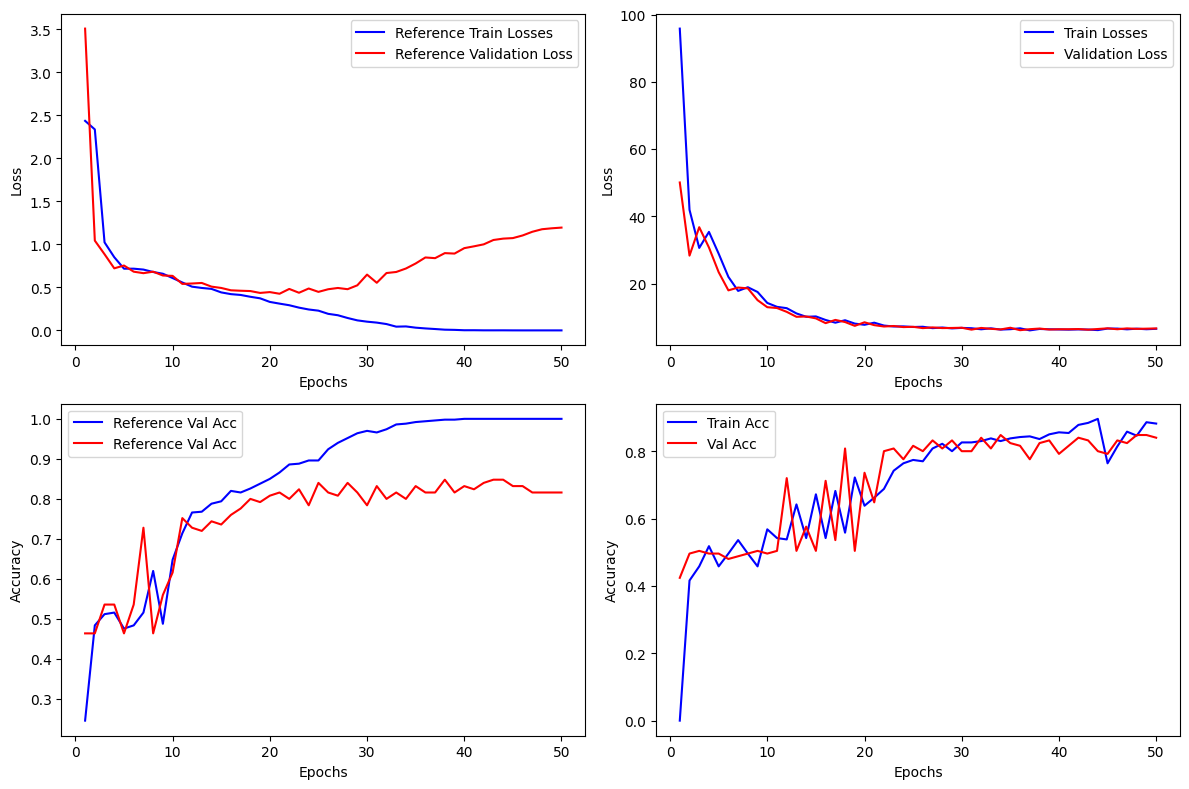

In [ ]:
plot_fig(ref_train_losses, ref_val_losses, ref_val_acc_list, ref_train_acc_list,train_losses, val_losses, val_acc_list, train_acc_list)

In [ ]:
# Example usage:
evaluate_model(modelL1,test_loader,criterion)

Test Loss: 0.4741, Test Accuracy: 79.75%: 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

Test Loss: 0.4741, Test Accuracy: 79.75%


(0.4741159238815308, 0.7975)

In [ ]:
#torch.save(model.state_dict(), '/kaggle/working/l1_model.pth')


In [ ]:

del modelL1
gc.collect()
torch.cuda.empty_cache()

In [ ]:

# Define the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the model
num_classes = 10  # CIFAR-10 has 10 classes
modelL2 = MyNet_l(num_classes=num_classes,l2_lambda = 0.035).to(device)

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values to range [-1, 1]
])
train_loader,val_loader,test_loader = getLoader(transform, transform)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelL2.parameters(), lr=0.001)

train_losses, val_losses, val_acc_list, train_acc_list = train_l(modelL2, train_loader, val_loader, criterion, optimizer, num_epochs= 50, isL1 = False)
#train_losses, val_losses, val_acc_list, train_acc_list = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)


Files already downloaded and verified
Files already downloaded and verified
10000
Training dataset size =  500
Validation dataset size =  125
Test dataset size =  2000


Epoch 50/50: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


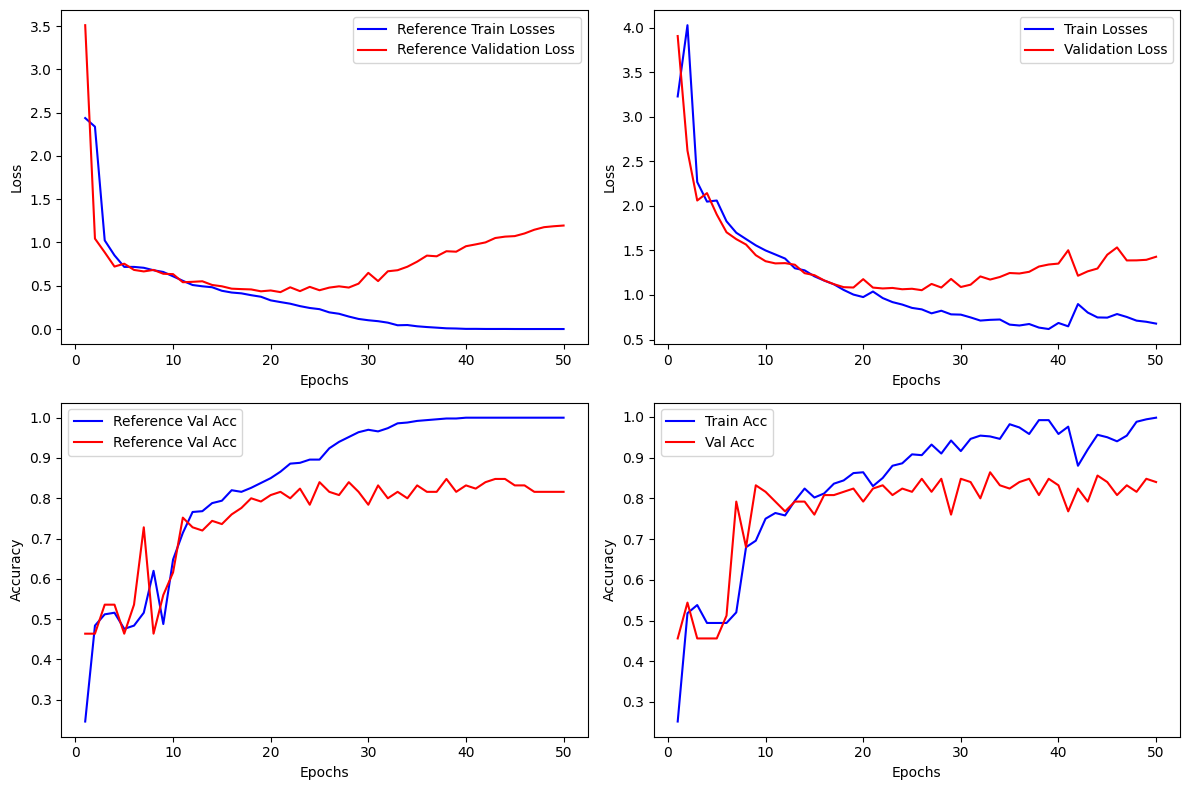

In [ ]:
plot_fig(ref_train_losses, ref_val_losses, ref_val_acc_list, ref_train_acc_list,train_losses, val_losses, val_acc_list, train_acc_list)

In [ ]:
# Example usage:
evaluate_model(modelL2, test_loader, criterion)

Test Loss: 0.5772, Test Accuracy: 84.05%: 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

Test Loss: 0.5772, Test Accuracy: 84.05%


(0.577155966758728, 0.8405)

In [ ]:
#torch.save(model.state_dict(), '/kaggle/working/l2_model.pth')
del modelL2
gc.collect()
torch.cuda.empty_cache()

In [ ]:
print("ref_train_losses = ",ref_train_losses)
print("ref_val_losses = ",ref_val_losses)
print("ref_val_acc_list = ",ref_val_acc_list)
print("ref_train_acc_list = ",ref_train_acc_list)

ref_train_losses =  [2.436741792678833, 2.337213949203491, 1.023976245880127, 0.8512363266944886, 0.7177285027503967, 0.7177145657539368, 0.7074700527191162, 0.6791732177734375, 0.658997350692749, 0.6089498591423035, 0.5572625780105591, 0.508527569770813, 0.4937185864448547, 0.48280247950553895, 0.44194583415985106, 0.4217806828022003, 0.41221767950057986, 0.3909915359020233, 0.37309602117538454, 0.33128810572624207, 0.3113966739177704, 0.2926714923381805, 0.26479482686519623, 0.2432701905965805, 0.2296401629447937, 0.1926880373954773, 0.1763547008037567, 0.14425995898246766, 0.11668597066402435, 0.10161966305971146, 0.09076639169454574, 0.0737989499270916, 0.04363103456795216, 0.046309160083532336, 0.03184061549603939, 0.023045460026711227, 0.01602441365271807, 0.008457044161856175, 0.006218128090724349, 0.0018793589640408754, 0.0020981821864843367, 0.0008786691352725029, 0.0007968551963567734, 0.0009722817977890373, 0.00040367676387541, 0.000219873578986153, 0.0002191728289471939, 0.

## Data Augmentation

Data augmentation is a technique used to artificially increase the size and diversity of a training dataset by applying various transformations to the original data samples. The goal of data augmentation is to improve the generalization performance of machine learning models by exposing them to a wider range of variations in the input data. This helps the model learn invariant features and become more robust to different conditions and variations present in real-world data.

Now, let's explain each transformation in the provided transform_augment sequence:

* **RandomHorizontalFlip**: This transformation randomly flips the input images horizontally with a certain probability (usually 0.5). It is commonly used in computer vision tasks to augment the dataset with horizontally flipped versions of the images. This helps the model to learn features that are invariant to left-right orientation.

* **ColorJitter**: This transformation randomly adjusts the brightness, contrast, saturation, and hue of the input images. By changing the color distribution of the images, ColorJitter helps the model to become more invariant to changes in lighting conditions and color variations in the input data.

* **RandomRotation**: This transformation randomly rotates the input images by a specified angle. Random rotation introduces variations in object orientation, which helps the model learn features that are invariant to rotation and improve its generalization performance.

In [ ]:
# Define transforms for data preprocessing
transform_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values to range [-1, 1]
])

In [ ]:
# Define transformations for test/validation set (without augmentation)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader,val_loader,test_loader = getLoader(transform_augment, transform_test)

Files already downloaded and verified
Files already downloaded and verified
10000
Training dataset size =  500
Validation dataset size =  125
Test dataset size =  2000


Epoch 50/50: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


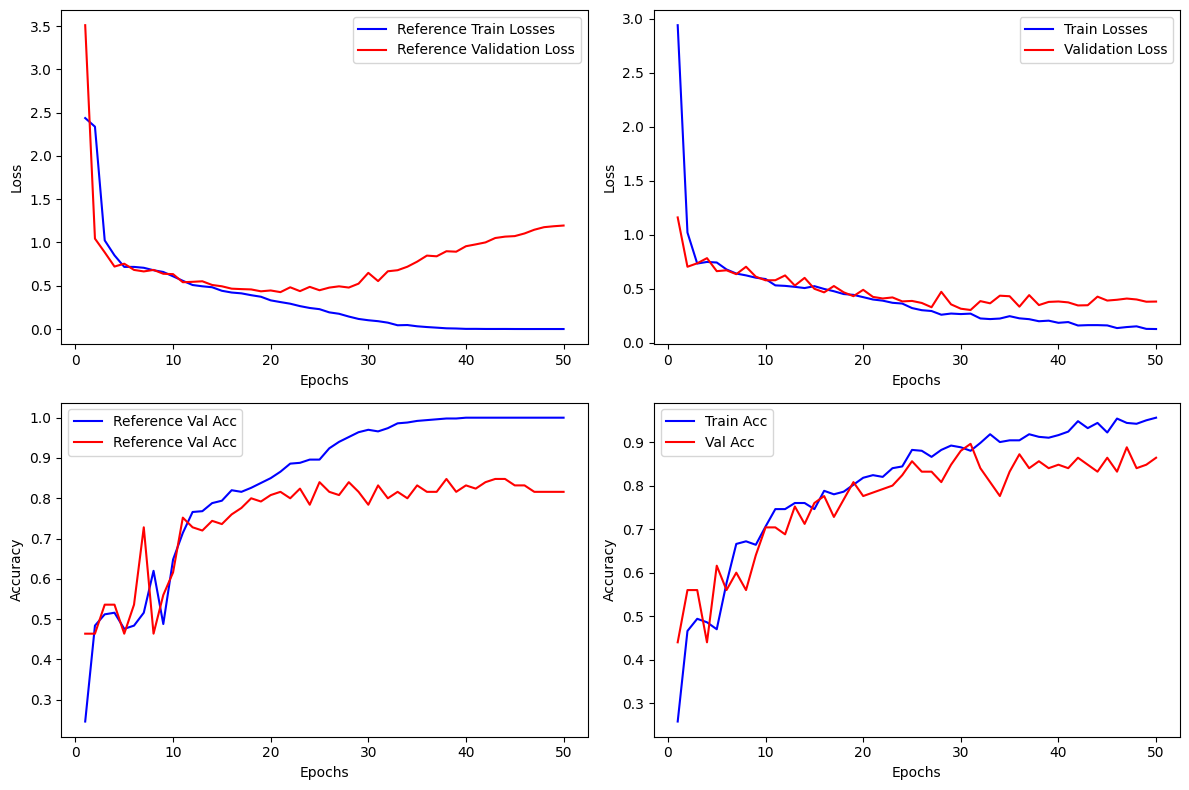

In [ ]:
# Define the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the model
num_classes = 10  # CIFAR-10 has 10 classes
#modelDataAug = MyNet(num_classes=num_classes).to(device)
modelDataAug = MyNet_l(num_classes=num_classes,l2_lambda = 0.00).to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelDataAug.parameters(), lr=0.001)

train_losses, val_losses, val_acc_list, train_acc_list = train_l(modelDataAug, train_loader, val_loader, criterion, optimizer, num_epochs=50, isL1 = False)
#train_losses, val_losses, val_acc_list, train_acc_list = train_model(modelDataAug, train_loader, val_loader, criterion, optimizer, num_epochs= 100)
plot_fig(ref_train_losses, ref_val_losses, ref_val_acc_list, ref_train_acc_list,train_losses, val_losses, val_acc_list, train_acc_list)

In [ ]:
# Example usage:
evaluate_model(modelDataAug, test_loader, criterion)

Test Loss: 0.3359, Test Accuracy: 87.85%: 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

Test Loss: 0.3359, Test Accuracy: 87.85%


(0.33586700916290285, 0.8785)

In [ ]:
del modelDataAug
gc.collect()
torch.cuda.empty_cache()

## Dropout + L2

Dropout is a regularization technique used in neural networks to prevent overfitting and improve generalization performance. It was introduced by Srivastava et al. in their paper "Dropout: A Simple Way to Prevent Neural Networks from Overfitting" (2014).

###**Intuition behind Dropout**:

The main idea behind dropout is to prevent complex co-adaptations of neurons by randomly deactivating a fraction of neurons during training. By doing so, dropout encourages the network to learn more robust and generalizable features, as it cannot rely on the presence of specific neurons for making predictions. Here's an intuitive explanation of how dropout works:

**Encouraging Redundancy**: During training, dropout randomly sets a fraction of neurons to zero with a certain probability (dropout rate). This forces the network to learn redundant representations, as it must be able to make accurate predictions even when some neurons are missing.

**Preventing Overfitting**: By randomly deactivating neurons, dropout effectively reduces the capacity of the network and prevents it from memorizing the training data. This helps prevent overfitting, where the model performs well on the training data but fails to generalize to unseen data.

**Ensemble Learning**: Dropout can be viewed as training multiple subnetworks with shared parameters. At test time, predictions are obtained by averaging the predictions of all these subnetworks. This ensemble approach helps reduce model variance and improve prediction accuracy.

### **Inverted Dropout:**

Inverted dropout is a specific implementation of dropout where the dropout is applied during training and scaled at test time. Here's how it works:

**During Training:** During each training iteration, dropout randomly sets a fraction of neurons to zero with a certain probability (dropout rate). However, to maintain the expected output of the network, the remaining activations are scaled by the inverse of the dropout rate.

**During Testing:** During testing or inference, dropout is turned off, and all neurons are used for making predictions. However, to ensure that the expected output remains the same as during training, the activations are scaled by the dropout rate (which is equivalent to keeping all neurons and not scaling the activations).

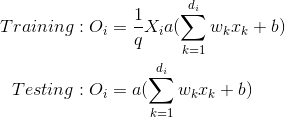

Inverted dropout is the most common form of dropout used in practice because it does not require any special treatment during testing and ensures that the network's behavior remains consistent between training and inference.

Because dropout is active only during training time but not inference time, without the scaling, the expected output would be larger during inference time because the elements are not being randomly chosen to be dropped (set to 0). But we want the expected output with and without going through the dropout layer to be the same. Therefore, during training, we compensate by making the output of the dropout layer larger by the scaling factor of 1/(1-p). A larger p means more aggressive dropout, which means the more compensation we need, i.e. the larger scaling factor 1/(1-p).

In [ ]:
class myDropout(nn.Module):
    def __init__(self, p = 0.7):
        super(myDropout, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = (torch.rand_like(x) > self.p) / (1 - self.p) ## Inverted dropout implementation
            return x * mask
        else:
            return x



class MyNet_Dropout(nn.Module):
    def __init__(self, num_classes, p = 0.7, l1_lambda = 0.1, l2_lambda = 0.05):
        super(MyNet_Dropout, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        self.p = p
        #self.classifier = nn.Sequential(*list(pretrained_alexnet.classifier.children())[:-1])  # Remove last fully connected layer
        self.classifier = nn.Sequential(
            nn.Linear(44944, 10000),  # New fully connected layer
            nn.ReLU(True),
            myDropout(),
            nn.Linear(10000, 1000),  # New fully connected layer
            nn.ReLU(True),
            #nn.Dropout(),
            myDropout(),
            nn.Linear(1000, 120),  # New fully connected layer
            nn.ReLU(True),
            myDropout(),
            nn.Linear(120, 84),
            nn.ReLU(True),
            #nn.Dropout(),
            myDropout(),
            nn.Linear(84, num_classes)
        )
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

    def l1_regularization(self):
        l1_reg = torch.tensor(0., device=self.features[0].weight.device)
        for param in self.parameters():
            l1_reg += torch.norm(param, p=1)
        return self.l1_lambda * l1_reg

    def l2_regularization(self):
        l2_reg = torch.tensor(0., device=self.features[0].weight.device)
        for name, param in self.named_parameters():
            if 'bias' not in name:
                l2_reg += torch.norm(param, p=2)  # same way for L1

        return 0.5 * self.l2_lambda * l2_reg


    def forward(self, x, train = True):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x


In [ ]:
# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG19 expects input images of size 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values to range [-1, 1]
])
train_loader,val_loader,test_loader = getLoader(transform, transform)

Files already downloaded and verified
Files already downloaded and verified
10000
Training dataset size =  500
Validation dataset size =  125
Test dataset size =  2000


Epoch 60/60: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


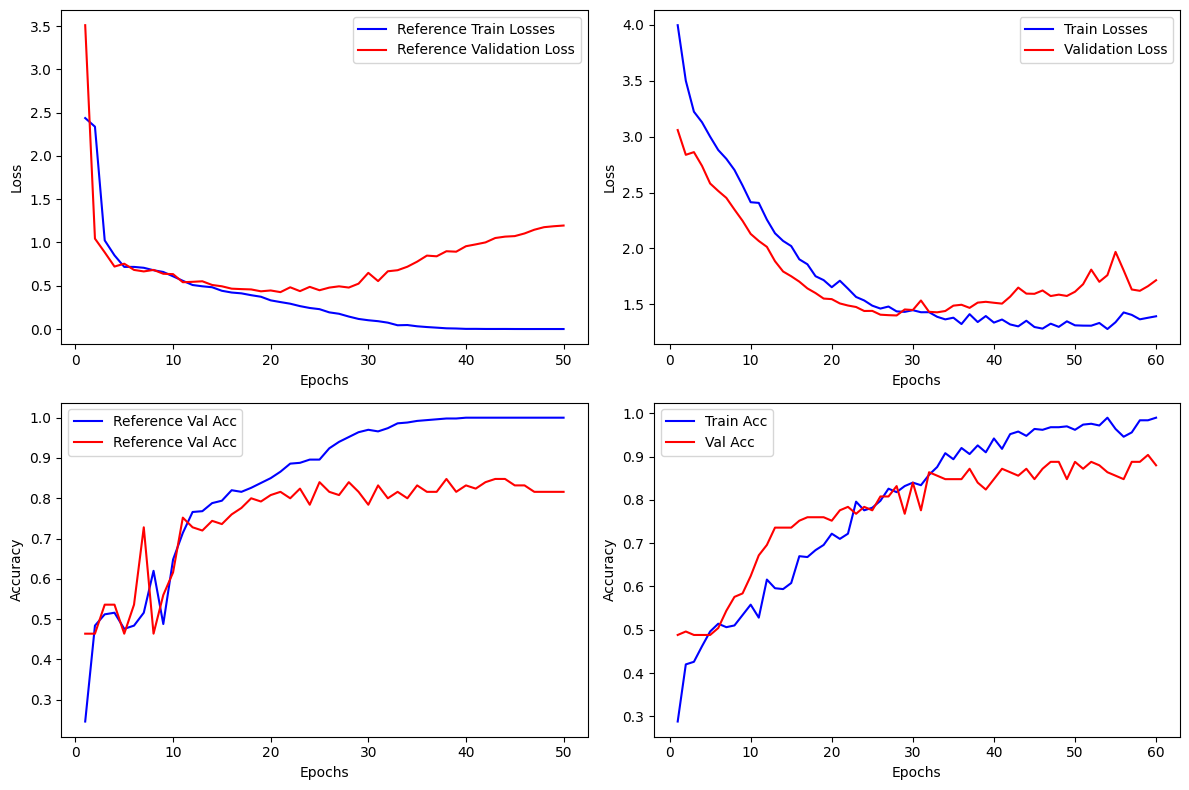

In [ ]:
# Define the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the model
num_classes = 10  # CIFAR-10 has 10 classes
modelDropout = MyNet_Dropout(num_classes=num_classes,l2_lambda = 0.04).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelDropout.parameters(), lr=0.001)

train_losses, val_losses, val_acc_list, train_acc_list = train_l(modelDropout, train_loader, val_loader, criterion, optimizer, num_epochs= 60,isL1 = False)
plot_fig(ref_train_losses, ref_val_losses, ref_val_acc_list, ref_train_acc_list,train_losses, val_losses, val_acc_list, train_acc_list)

In [ ]:
# Example usage:
evaluate_model(modelDropout, test_loader, criterion)

Test Loss: 0.4679, Test Accuracy: 86.60%: 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

Test Loss: 0.4679, Test Accuracy: 86.60%


(0.46790790057182313, 0.866)

In [ ]:
del modelDropout
gc.collect()
torch.cuda.empty_cache()


## Additional resources

https://discuss.pytorch.org/t/how-is-your-experience-of-using-l1-regularization/153565

https://spotintelligence.com/2023/05/26/l1-l2-regularization/

https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/

https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

https://stackoverflow.com/questions/54109617/implementing-dropout-from-scratch
